In [ ]:
import pandas as pd
import os
import sys

project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.append(project_root)

from utils.cmod5n import cmod5n_forward, cmod5n_inverse
from utils.functions import *

import xarray as xr
from glob import glob

In [ ]:
ds = xr.open_dataset(glob("../processed_data/Sentinel1/WV/2020/*.nc")[0])

In [ ]:
df1 = pd.read_parquet("../processed_data/wv1_complete.parquet")
df2 = pd.read_parquet("../processed_data/wv2_complete.parquet")

df1 = create_phi_bins_columns(df1)
df2 = create_phi_bins_columns(df2)

df1r = pd.read_parquet("../results/wv1_results_updated.parquet")
df2r = pd.read_parquet("../results/wv2_results_updated.parquet")

df1w = pd.read_parquet("../results/wv1_wind_results.parquet")
df2w = pd.read_parquet("../results/wv2_wind_results.parquet")

df1r["renamed_filename"] = df1r.sar_filepath.apply(lambda x: x.split("/")[-1])
df2r["renamed_filename"] = df2r.sar_filepath.apply(lambda x: x.split("/")[-1])

df1w["renamed_filename"] = df1w.sar_filepath.apply(lambda x: x.split("/")[-1])
df2w["renamed_filename"] = df2w.sar_filepath.apply(lambda x: x.split("/")[-1])

idxmax = df1w.k_values_wind.apply(lambda x: len(x)).argmax()
max_len = df1w.k_values_wind.apply(lambda x: len(x)).max()

df1r = pad_arrays_to_max_length(df1r, 'radial_psd', max_len)
df2r = pad_arrays_to_max_length(df2r, 'radial_psd', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_wind_psd', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_wind_psd', max_len)

In [ ]:
k_values = get_k_values(df1r, "k_values")
k_values = k_values/20

In [ ]:
df1_rg, df1r_rg, df1w_rg = create_dfs_from_phi_interval('[-90, -89)', df1, df1r, df1w)
df2_rg, df2r_rg, df2w_rg = create_dfs_from_phi_interval('[-90, -89)', df2, df2r, df2w)

Performing block bootstrap with 14 samples, block size 3, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 30640.18it/s]


Performing block bootstrap with 21 samples, block size 4, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 32259.66it/s]


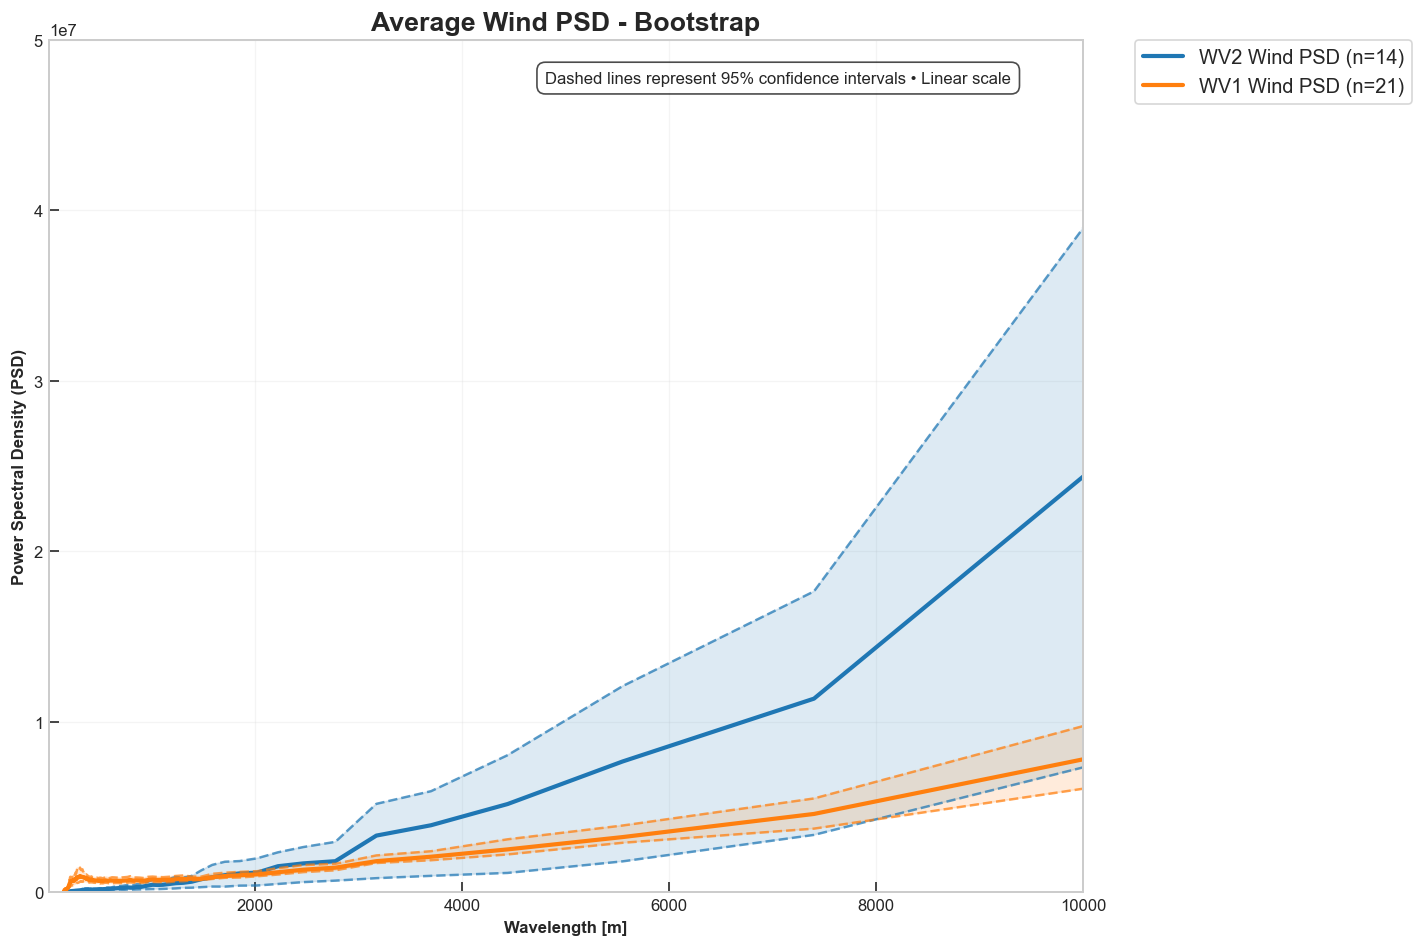

In [ ]:
plot_avg_spectral_density(k_values, [df2w_rg, df1w_rg], ["WV2 Wind PSD", "WV1 Wind PSD"],
                          "Average Wind PSD", 
                          x_range=(0.0001, 0.15), y_range=(0, 0.5e8), 
                          use_log_scale=False, wavelength=True, bootstrap=True);

In [ ]:
# d = compute_directional_differences(df1, df2, df1r, df2r, df1w, df2w, k_values, phi_res=1)
# plot_directional_differences(d, k_values, plot_type='wavelength', cmap='RdBu_r', 
#                              max_wavelength=100, vmin=-1e6, vmax=1e6)

Performing block bootstrap with 1040 samples, block size 32, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 1015.04it/s]


Performing block bootstrap with 1132 samples, block size 33, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 997.67it/s]


Performing block bootstrap with 418 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 6482.60it/s]


Performing block bootstrap with 405 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 6710.95it/s]


Performing block bootstrap with 254 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 11349.36it/s]


Performing block bootstrap with 255 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 10038.23it/s]


Performing block bootstrap with 237 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 9552.24it/s]


Performing block bootstrap with 259 samples, block size 16, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 11373.80it/s]


Performing block bootstrap with 407 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 7509.18it/s]


Performing block bootstrap with 446 samples, block size 21, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 6691.92it/s]


Performing block bootstrap with 1369 samples, block size 37, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 921.27it/s]


Performing block bootstrap with 1448 samples, block size 38, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 881.17it/s]


Performing block bootstrap with 2278 samples, block size 47, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 561.39it/s]


Performing block bootstrap with 2381 samples, block size 48, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 509.90it/s]


Performing block bootstrap with 1338 samples, block size 36, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 845.94it/s]


Performing block bootstrap with 1262 samples, block size 35, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 974.14it/s]


Performing block bootstrap with 541 samples, block size 23, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4531.50it/s]


Performing block bootstrap with 518 samples, block size 22, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 5248.32it/s]


Performing block bootstrap with 641 samples, block size 25, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 3905.51it/s]


Performing block bootstrap with 542 samples, block size 23, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4989.43it/s]


Performing block bootstrap with 1848 samples, block size 42, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 637.92it/s]


Performing block bootstrap with 1781 samples, block size 42, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 728.13it/s]


Performing block bootstrap with 2218 samples, block size 47, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 613.11it/s]


Performing block bootstrap with 2171 samples, block size 46, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 618.25it/s]


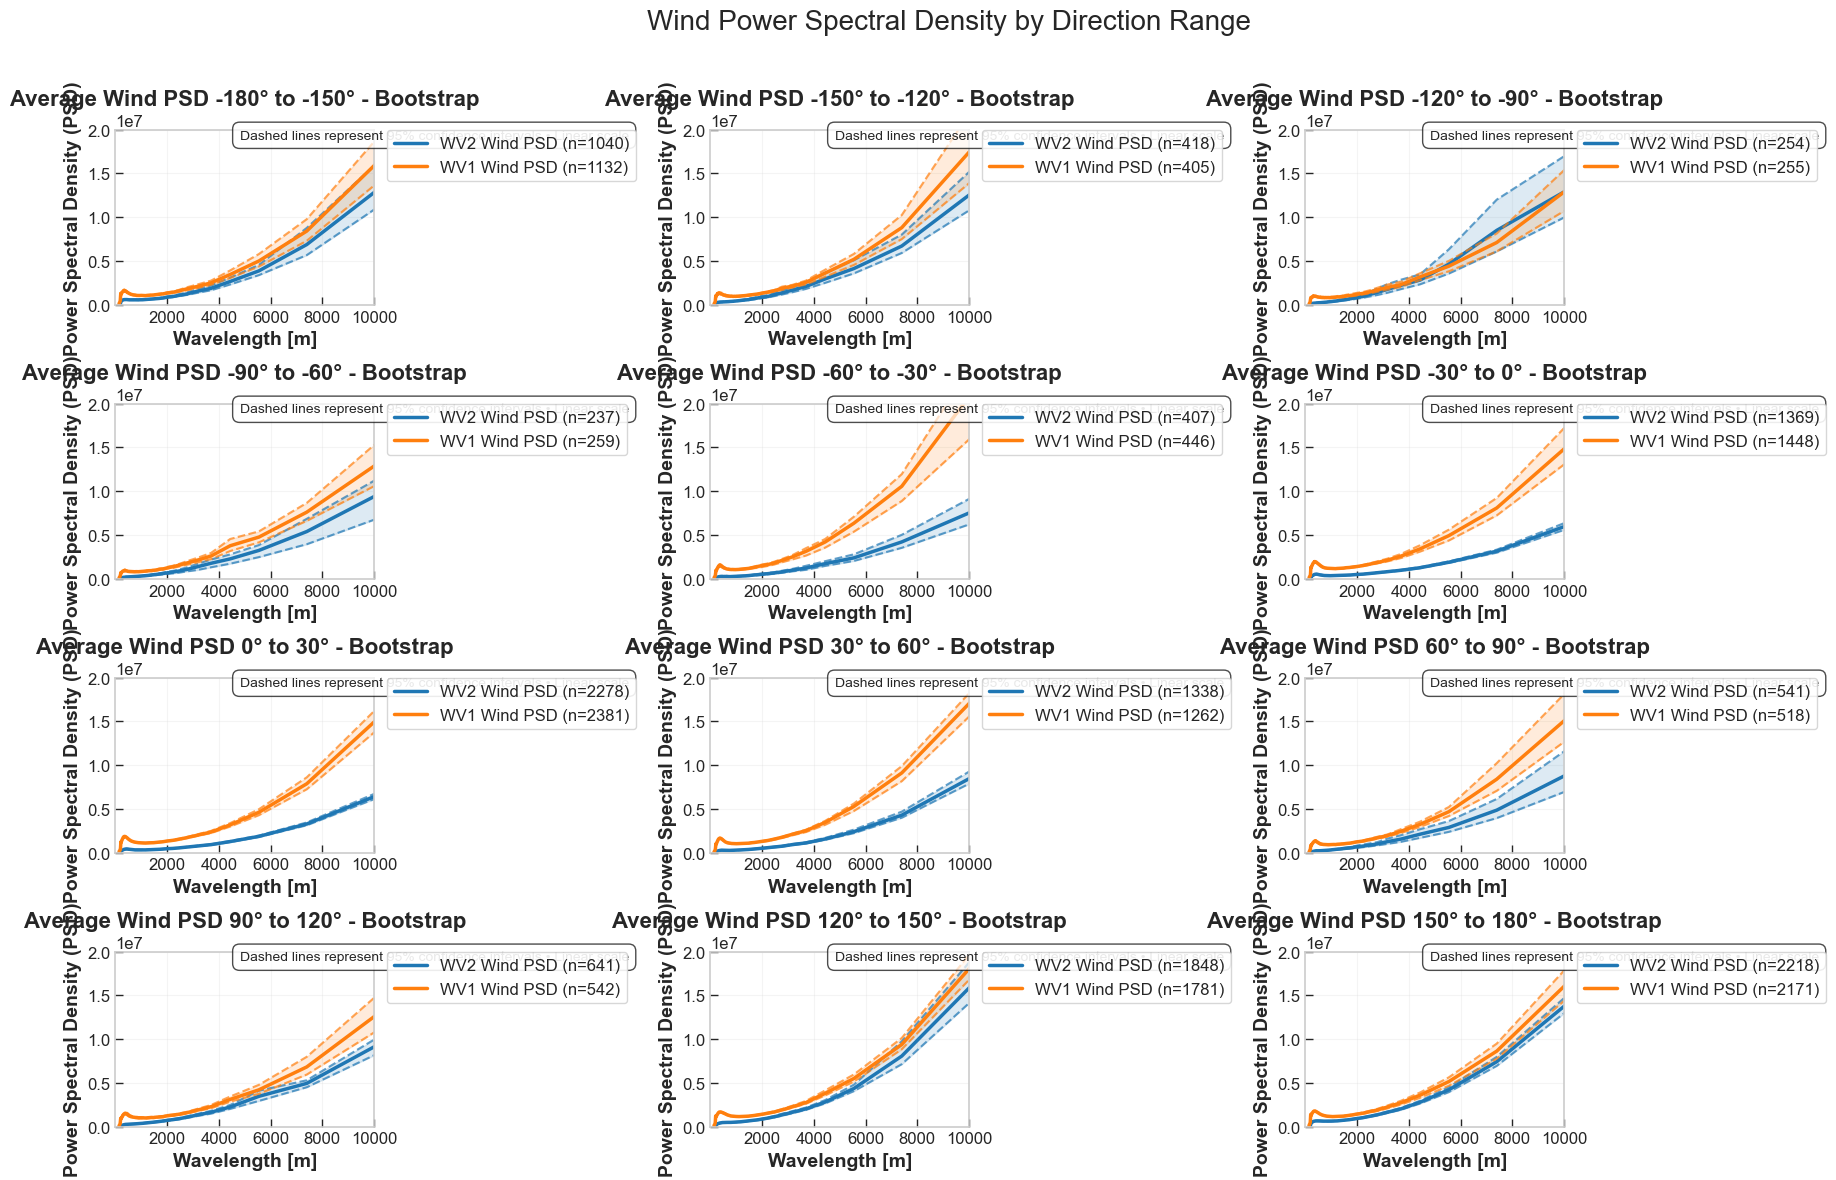

In [ ]:
intervals = np.arange(-180, 181, 30)

# Create the figure and axes
fig, axes = plt.subplots(4, 3, figsize=(18, 12))

# Flatten the 2D array of axes
flat_axes = axes.flatten()

for i in range(len(intervals)-1):
    a = intervals[i]
    b = intervals[i+1]
    
    # Skip if we've run out of axes
    if i >= len(flat_axes):
        print(f"Warning: Not enough axes for interval {a} to {b}")
        continue
        
    # Get the current axis
    current_ax = flat_axes[i]
    
    # Construct filtered DataFrames for the current interval
    df1_filtered, df1r_filtered, df1w_filtered, df2_filtered, df2r_filtered, df2w_filtered = construct_df(a, b, df1, df1r, df1w, df2, df2r, df2w)
    df1_filtered = filter_similar_atmospheric_conditions(df1_filtered, L_range=(-1e6, -1000))
    df2_filtered = filter_similar_atmospheric_conditions(df2_filtered, L_range=(-1e6, -1000))

    df1r_filtered = df1r_filtered[df1r_filtered["renamed_filename"].isin(df1_filtered["renamed_filename"])]
    df2r_filtered = df2r_filtered[df2r_filtered["renamed_filename"].isin(df2_filtered["renamed_filename"])]

    df1w_filtered = df1w_filtered[df1w_filtered["renamed_filename"].isin(df1_filtered["renamed_filename"])]
    df2w_filtered = df2w_filtered[df2w_filtered["renamed_filename"].isin(df2_filtered["renamed_filename"])]

    # Plot on the current axis
    _, _ = plot_avg_spectral_density(k_values, [df2w_filtered, df1w_filtered],
                              ["WV2 Wind PSD", "WV1 Wind PSD"],
                              f"$\\phi \\in$ [{a}°, {b}°)", 
                              x_range=(0.0001, 0.15), y_range=(0, 0.2e8), 
                              use_log_scale=False, wavelength=True, bootstrap=True,
                              ax=current_ax)  

# Hide any unused axes
for j in range(i+1, len(flat_axes)):
    flat_axes[j].set_visible(False)

# Add a common title for the entire figure
fig.suptitle('Wind Power Spectral Density by Direction Range', fontsize=20, y=0.98)

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # The rect parameter reserves space for the suptitle

# Show the figure
plt.show()

In [ ]:
# df1_m180_m150, df1r_m180_m150, df1w_m180_m150, df2_m180_m150, df2r_m180_m150, df2w_m180_m150 = construct_df(-180, -150, df1, df1r, df1w, df2, df2r, df2w)
# df1_m150_m120, df1r_m150_m120, df1w_m150_m120, df2_m150_m120, df2r_m150_m120, df2w_m150_m120 = construct_df(-150, -120, df1, df1r, df1w, df2, df2r, df2w)
# df1_m120_m90, df1r_m120_m90, df1w_m120_m90, df2_m120_m90, df2r_m120_m90, df2w_m120_m90 = construct_df(-120, -90, df1, df1r, df1w, df2, df2r, df2w)
# df1_m90_m60, df1r_m90_m60, df1w_m90_m60, df2_m90_m60, df2r_m90_m60, df2w_m90_m60 = construct_df(-90, -60, df1, df1r, df1w, df2, df2r, df2w)
# df1_m60_m30, df1r_m60_m30, df1w_m60_m30, df2_m60_m30, df2r_m60_m30, df2w_m60_m30 = construct_df(-60, -30, df1, df1r, df1w, df2, df2r, df2w)
# df1_m30_0, df1r_m30_0, df1w_m30_0, df2_m30_0, df2r_m30_0, df2w_m30_0 = construct_df(-30, 0, df1, df1r, df1w, df2, df2r, df2w)
# df1_0_30, df1r_0_30, df1w_0_30, df2_0_30, df2r_0_30, df2w_0_30 = construct_df(0, 30, df1, df1r, df1w, df2, df2r, df2w)
# df1_30_60, df1r_30_60, df1w_30_60, df2_30_60, df2r_30_60, df2w_30_60 = construct_df(30, 60, df1, df1r, df1w, df2, df2r, df2w)
# df1_60_90, df1r_60_90, df1w_60_90, df2_60_90, df2r_60_90, df2w_60_90 = construct_df(60, 90, df1, df1r, df1w, df2, df2r, df2w)
# df1_90_120, df1r_90_120, df1w_90_120, df2_90_120, df2r_90_120, df2w_90_120 = construct_df(90, 120, df1, df1r, df1w, df2, df2r, df2w)
# df1_120_150, df1r_120_150, df1w_120_150, df2_120_150, df2r_120_150, df2w_120_150 = construct_df(120, 150, df1, df1r, df1w, df2, df2r, df2w)
# df1_150_180, df1r_150_180, df1w_150_180, df2_150_180, df2r_150_180, df2w_150_180 = construct_df(150, 180, df1, df1r, df1w, df2, df2r, df2w)

In [ ]:
# df1_reconstructed = pd.concat([df1_m180_m150, df1_m150_m120, df1_m120_m90, df1_m90_m60, df1_m60_m30, df1_m30_0,
#                                df1_0_30, df1_30_60, df1_60_90, df1_90_120, df1_120_150, df1_150_180], ignore_index=True)

# df2_reconstructed = pd.concat([df2_m180_m150, df2_m150_m120, df2_m120_m90, df2_m90_m60, df2_m60_m30, df2_m30_0,
#                                  df2_0_30, df2_30_60, df2_60_90, df2_90_120, df2_120_150, df2_150_180], ignore_index=True)

Number of r values after filtering: 91
Min/max r after filtering: 46.81, 118.21


(<Figure size 1200x1000 with 2 Axes>,
 <PolarAxes: title={'center': 'Directional Differences - Filtered - L_range (-1000000.0, -1000)'}>)

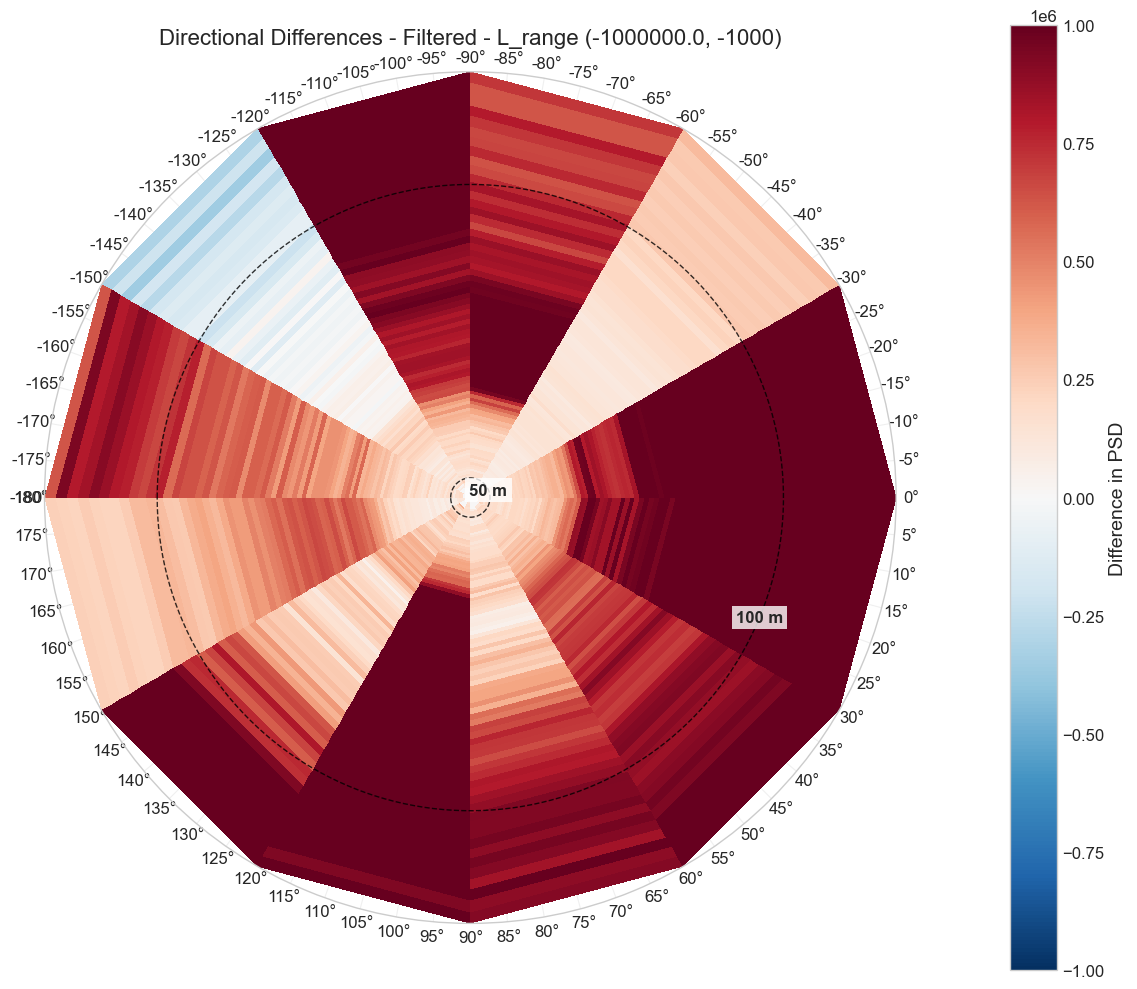

In [ ]:
# filtered_df1 = filter_similar_atmospheric_conditions(df1_reconstructed, L_range=(-1e6, -1000))
# filtered_df2 = filter_similar_atmospheric_conditions(df2_reconstructed, L_range=(-1e6, -1000))
# filtered_df1r = df1r[df1r["renamed_filename"].isin(filtered_df1["renamed_filename"])]
# filtered_df2r = df2r[df2r["renamed_filename"].isin(filtered_df2["renamed_filename"])]
# filtered_df1w = df1w[df1w["renamed_filename"].isin(filtered_df1["renamed_filename"])]
# filtered_df2w = df2w[df2w["renamed_filename"].isin(filtered_df2["renamed_filename"])]

# d = compute_directional_differences(filtered_df1, filtered_df2,
#                                     filtered_df1r, filtered_df2r, 
#                                     filtered_df1w, filtered_df2w, 
#                                     k_values=k_values, phi_res=30)

# plot_directional_differences(d, k_values, plot_type='wavelength', cmap='RdBu_r',
#                                 max_wavelength=120, vmin=-1e6, vmax=1e6,
#                                 title=f"Directional Differences - Filtered - L_range {(-1e6, -1000)}")

In [ ]:
# # wspd_range = (18, 19)
# L_ranges = [(-1e6, -1000), (-1000, -500), (-500, 0)]
# ds = []
# for L_range in L_ranges:
#     filtered_df1 = filter_similar_atmospheric_conditions(df1, L_range=L_range)
#     filtered_df2 = filter_similar_atmospheric_conditions(df2, L_range=L_range)

#     filtered_df1r = df1r[df1r['renamed_filename'].isin(filtered_df1['renamed_filename'])]
#     filtered_df2r = df2r[df2r['renamed_filename'].isin(filtered_df2['renamed_filename'])]

#     filtered_df1w = df1w[df1w['renamed_filename'].isin(filtered_df1['renamed_filename'])]
#     filtered_df2w = df2w[df2w['renamed_filename'].isin(filtered_df2['renamed_filename'])]

#     filtered_df1_rg_uw = filter_similar_atmospheric_conditions(df1_rg_uw, L_range=L_range)
#     filtered_df2_rg_uw = filter_similar_atmospheric_conditions(df2_rg_uw, L_range=L_range)
#     filtered_df1r_rg_uw = df1r_rg_uw[df1r_rg_uw['renamed_filename'].isin(filtered_df1_rg_uw['renamed_filename'])]
#     filtered_df2r_rg_uw = df2r_rg_uw[df2r_rg_uw['renamed_filename'].isin(filtered_df2_rg_uw['renamed_filename'])]
#     filtered_df1w_rg_uw = df1w_rg_uw[df1w_rg_uw['renamed_filename'].isin(filtered_df1_rg_uw['renamed_filename'])]
#     filtered_df2w_rg_uw = df2w_rg_uw[df2w_rg_uw['renamed_filename'].isin(filtered_df2_rg_uw['renamed_filename'])]

#     filtered_df1_rg_dw = filter_similar_atmospheric_conditions(df1_rg_dw, L_range=L_range)
#     filtered_df2_rg_dw = filter_similar_atmospheric_conditions(df2_rg_dw, L_range=L_range)
#     filtered_df1r_rg_dw = df1r_rg_dw[df1r_rg_dw['renamed_filename'].isin(filtered_df1_rg_dw['renamed_filename'])]
#     filtered_df2r_rg_dw = df2r_rg_dw[df2r_rg_dw['renamed_filename'].isin(filtered_df2_rg_dw['renamed_filename'])]
#     filtered_df1w_rg_dw = df1w_rg_dw[df1w_rg_dw['renamed_filename'].isin(filtered_df1_rg_dw['renamed_filename'])]
#     filtered_df2w_rg_dw = df2w_rg_dw[df2w_rg_dw['renamed_filename'].isin(filtered_df2_rg_dw['renamed_filename'])]

#     filtered_df1_az_lr = filter_similar_atmospheric_conditions(df1_az_lr, L_range=L_range)
#     filtered_df2_az_lr = filter_similar_atmospheric_conditions(df2_az_lr, L_range=L_range)
#     filtered_df1r_az_lr = df1r_az_lr[df1r_az_lr['renamed_filename'].isin(filtered_df1_az_lr['renamed_filename'])]
#     filtered_df2r_az_lr = df2r_az_lr[df2r_az_lr['renamed_filename'].isin(filtered_df2_az_lr['renamed_filename'])]
#     filtered_df1w_az_lr = df1w_az_lr[df1w_az_lr['renamed_filename'].isin(filtered_df1_az_lr['renamed_filename'])]
#     filtered_df2w_az_lr = df2w_az_lr[df2w_az_lr['renamed_filename'].isin(filtered_df2_az_lr['renamed_filename'])]

#     filtered_df1_az_rl = filter_similar_atmospheric_conditions(df1_az_rl, L_range=L_range)
#     filtered_df2_az_rl = filter_similar_atmospheric_conditions(df2_az_rl, L_range=L_range)
#     filtered_df1r_az_rl = df1r_az_rl[df1r_az_rl['renamed_filename'].isin(filtered_df1_az_rl['renamed_filename'])]
#     filtered_df2r_az_rl = df2r_az_rl[df2r_az_rl['renamed_filename'].isin(filtered_df2_az_rl['renamed_filename'])]
#     filtered_df1w_az_rl = df1w_az_rl[df1w_az_rl['renamed_filename'].isin(filtered_df1_az_rl['renamed_filename'])]
#     filtered_df2w_az_rl = df2w_az_rl[df2w_az_rl['renamed_filename'].isin(filtered_df2_az_rl['renamed_filename'])]

#     plot_avg_spectral_density(k_values, [filtered_df2w_rg_uw, filtered_df1w_rg_uw], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - rg uw", 
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7), 
#                             use_log_scale=False, wavelength=True);

    
#     plot_avg_spectral_density(k_values, [filtered_df2w_rg_dw, filtered_df1w_rg_dw], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - rg dw",
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7),
#                             use_log_scale=False, wavelength=True);
    
#     plot_avg_spectral_density(k_values, [filtered_df2w_az_lr, filtered_df1w_az_lr], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - az lr",
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7),
#                             use_log_scale=False, wavelength=True);
    
#     plot_avg_spectral_density(k_values, [filtered_df2w_az_rl, filtered_df1w_az_rl], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - az rl",
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7),
#                             use_log_scale=False, wavelength=True);

#     d = compute_directional_differences(filtered_df1, filtered_df2,
#                                         filtered_df1r, filtered_df2r, 
#                                         filtered_df1w, filtered_df2w, 
#                                         k_values=k_values, phi_res=5)
    
#     plot_directional_differences(d, k_values, plot_type='wavelength', cmap='RdBu_r',
#                                  max_wavelength=120, vmin=-1e6, vmax=1e6,
#                                  title=f"Directional Differences - Filtered - L_range {L_range}")

In [ ]:
# d = compute_directional_differences(df1, df2, df1r, df2r, df1w, df2w, k_values, phi_res=5)

In [ ]:
# plot_directional_differences(d, k_values, plot_type='wavelength', cmap='RdBu_r', 
#                              max_wavelength=100, vmin=-1e6, vmax=1e6)